<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [2]:
%pip install pandarallel

import re 
#from pymystem3 import Mystem
import warnings



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#from tqdm import tqdm # библиотека для отображения прогресса
from tqdm.notebook import tqdm
tqdm.pandas()

import nltk
from nltk.corpus import stopwords 
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score


from pandarallel import pandarallel   
tqdm.pandas(desc="progress")
pandarallel.initialize(progress_bar = True)

#from wordcloud import WordCloud 
import matplotlib.pyplot as plt
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [4]:
# Инизиализируем параллельное выполнение операций в Pandas 
#pandarallel.initialize(progress_bar=True) #постоянно выдает ошибки, поэтому не использую, хотя нужно бы

# Задаем количество столбцов, которые будут выводиться при обращении к датафреймам
pd.set_option('display.max_columns', None)  

# Задаем количество знаков после запятой для всех значений в датафрейме
pd.set_option('float_format', '{:.2f}'.format) 

# Вывести из под комментария перед финальным запуском:
# Игнорируем предупреждения о возможных изменения работы функций в будущих версиях в Pandas
warnings.filterwarnings("ignore") 

<b>создаем функции для дальнейшего использования

In [5]:
# функция для поиска грубых паттернов в комментариях

def find_pattern(text, pattern):
    """Returns a string containing all words in the pattern"""
    import re
    return ' '.join(re.findall(pattern, text.lower()))

# функция для поиска длины самого длинного слова в комментарии

def get_max_length(text):
    """Returns the longest word in the text"""
    import numpy as np
    if len(text) == 0: return ''
    words = text.split()
    lengths = [len(w) for w in words]
    return words[np.argmax(lengths)]

# функция для поиска и применения частей речи для лемматизации
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


<b>Знакомство с данными

In [6]:
#считываем данные из файла

try:
    main_df = pd.read_csv('toxic_comments.csv', index_col=[0])
except:
    main_df = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])

In [7]:
 main_df.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [8]:
print(f'Размер исследуемого набора данных: {main_df.shape}')

Размер исследуемого набора данных: (159292, 2)


In [9]:
#количество токсичных комментариев

main_df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

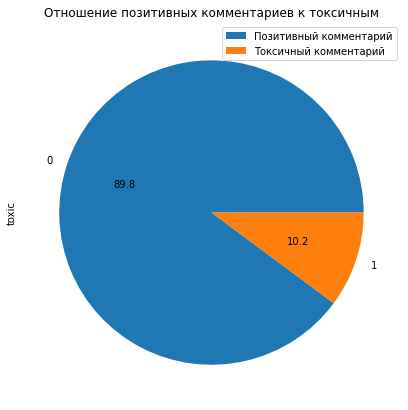

In [10]:
main_df['toxic'].value_counts().plot(kind='pie', autopct='%.1f', figsize=(7,7))
plt.legend(['Позитивный комментарий','Токсичный комментарий'])
plt.title('Отношение позитивных комментариев к токсичным');

<b>Промежуточный вывод </b>

* Язык комментариев - английский
* Предоставленные данные имеют дисбаланс классов, токсичных комментариев всего 1/10 часть от общего числа
* Всего в данных больше 159 тысяч строк (комментариев)
* В строках содержатся cпец.символы, которые необходимо обработать

In [11]:
# сделаем копию датасета, чтобы к изначальному можно было обратиться в процессе работы

df = main_df.copy(deep=True)

In [12]:
df.isna().sum()

text     0
toxic    0
dtype: int64

данные не содержат пропусков

In [13]:
df.duplicated().sum()

0

данные не содержат дубликатов

In [14]:
df[ 'longest_word'] = df.text.apply(get_max_length)
df.head()

,text,toxic,longest_word
0,Explanation\nWhy the edits made under my usern...,0,now.89.205.38.27
1,D'aww! He matches this background colour I'm s...,0,background
2,"Hey man, I'm really not trying to edit war. It...",0,information
3,"""\nMore\nI can't make any real suggestions on ...",0,Wikipedia:Good_article_nominations#Transport
4,"You, sir, are my hero. Any chance you remember...",0,remember


In [15]:
df['max_word_length'] = df.longest_word.str.len()
df.sort_values(by='max_word_length', ascending=False).head(10)

,text,toxic,longest_word,max_word_length
38614,Hate you \n\ni;uhbsirtubgyihihlkjngkjbnkgjnbkj...,1,i;uhbsirtubgyihihlkjngkjbnkgjnbkjfgnbknfgjkbnk...,4958
11786,==U R GAY== \n\nFUCKFUCKFUCKFUCKFUCKFUCKFUCKFU...,1,FUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFUCKFU...,4955
115507,Feel the might of Cyber Apocalypse! \n\nyyyyyy...,0,yyyyyyyyyyyyyyybvgtfrrrrrbyyyyyyyyyyyyyyyyyyyy...,4931
90224,I shall purge this web site of the weak! \n\nh...,1,hyyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyuyu...,4926
36065,Death To Wikipedia! Down with free Speach! \n\...,1,hjyunnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn...,4924
101286,Gaaaaaaaaaaaaaaaaaaaaaaaaay! U r fucking gaey!...,1,Gaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa...,4920
105646,Your Web Site is As useless to the public as i...,1,tytytytytytytytytytytytytytytytytytytytytytyty...,4876
85135,Lolapaloozas Preachy Fuck Award \n\nGiven for ...,1,http://en.wikipedia.org/wiki/User_talk:AntiVMa...,4840
135759,why don't you suck my ass until your lips blee...,1,AGAIN!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,4819
40809,Discussion destroying CRAP topic \n\nIt seems ...,1,CRAPCRAPCRAPCRAPCRAPCRAPCRAPCRAPCRAPCRAPCRAPCR...,4702


In [16]:
#длина сообщений 
df['length'] = df.text.str.len()
df.length.describe()

count   159292.00
mean       393.69
std        590.11
min          5.00
25%         95.00
50%        205.00
75%        435.00
max       5000.00
Name: length, dtype: float64

In [17]:
# количество слов в комментариях
df['n_words'] = df.text.apply(lambda x: len(x.split()))
df.n_words.describe()

count   159292.00
mean        67.21
std         99.13
min          1.00
25%         17.00
50%         36.00
75%         75.00
max       1411.00
Name: n_words, dtype: float64

In [18]:
df.head()

,text,toxic,longest_word,max_word_length,length,n_words
0,Explanation\nWhy the edits made under my usern...,0,now.89.205.38.27,16,264,43
1,D'aww! He matches this background colour I'm s...,0,background,10,112,17
2,"Hey man, I'm really not trying to edit war. It...",0,information,11,233,42
3,"""\nMore\nI can't make any real suggestions on ...",0,Wikipedia:Good_article_nominations#Transport,44,622,113
4,"You, sir, are my hero. Any chance you remember...",0,remember,8,67,13


In [19]:
#посмотрим сочетаются ли сверхдлинные слова с токсичностью, положим, что "сверхдиннные" слова - это слова от 400 символов
df_1 = df[df['max_word_length'] > 400]
df_1.info()
df_1['toxic'].value_counts()
#display(df[df.toxic == 1]['length'].describe())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 11786 to 144837
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             35 non-null     object
 1   toxic            35 non-null     int64 
 2   longest_word     35 non-null     object
 3   max_word_length  35 non-null     int64 
 4   length           35 non-null     int64 
 5   n_words          35 non-null     int64 
dtypes: int64(4), object(2)
memory usage: 1.9+ KB


1    20
0    15
Name: toxic, dtype: int64

Вывод: больше половины из комментариев, содержащих сверхдлинные слова, токсичны, но их общее количество невелико, поэтому нельзя однозначно сказать ,что сверхдлинные слова сочетаются с токсичностью. Далее мы создадим паттерн с некоторыми грубыми лексемами, создадим признаки на его основе и изучим соответствие наличия грубости токсичности сообщения.

<b>Паттерн грубости

In [20]:
rudeness_pattern = re.compile(r'bitch|crap|gay|fuck|fuk|fucking|cunt|basta|puke|vomit|boner|sod off|bugger|tosser| cock|nigger|nigga|hate you|piss off|shut up|suck|shit|damn|dick|twat|queer|faggot|jerk|buttocs|dumb|bloody')
df['rude'] = df.text.apply(find_pattern, pattern=rudeness_pattern)
df['rudeness'] = df.rude.apply(lambda x: len(x) > 0)
print('Done')

Done


In [21]:
df.sort_values(by='rude', ascending=False).head(10)

,text,toxic,longest_word,max_word_length,length,n_words,rude,rudeness
48241,VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMIT VOMI...,1,VOMIT,5,1289,215,vomit vomit vomit vomit vomit vomit vomit vomi...,True
41579,"""\nI agree, we could do better, and the ideal ...",0,tasteful/better,15,675,121,vomit vomit vomit,True
63413,im a vomit lover \n\nyourname\n\ni love it whe...,1,yourname,8,61,13,vomit vomit,True
51921,SMELL MY ARSE\n\nPROJECTILE VOMIT INTO MY GAPI...,1,PROJECTILE,10,90,15,vomit shit,True
18086,You swine. You vulgar little maggot. You worth...,1,Dehydrated-rock-hard,20,4858,833,vomit jerk suck puke bloody bugger tosser coc...,True
112837,Pretty sure they farted on the monster until i...,1,monster,7,100,19,vomit fuck,True
45113,HELp SIR\nTHE MARXIST CHRISTIAN SICKOS ARE BAC...,1,SMARTERCHILDTHREE,17,675,109,vomit crap,True
7071,Makes me want to vomit\nThe way they're hand h...,0,especially,10,367,67,vomit crap,True
131524,I will force you to eat dog poop. \n\nIt will ...,1,watching,8,117,24,vomit crap,True
14425,"""\n\n Remedies \n\nThese were removed from the...",0,gluconeogenesis.,16,4417,684,vomit bloody,True


In [22]:
df['rudeness'].value_counts()

False    147434
True      11858
Name: rudeness, dtype: int64

In [23]:
df_2 = df[df['rude'] != ''] #датасет с грубыми комментариями
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11858 entries, 6 to 159434
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             11858 non-null  object
 1   toxic            11858 non-null  int64 
 2   longest_word     11858 non-null  object
 3   max_word_length  11858 non-null  int64 
 4   length           11858 non-null  int64 
 5   n_words          11858 non-null  int64 
 6   rude             11858 non-null  object
 7   rudeness         11858 non-null  bool  
dtypes: bool(1), int64(4), object(3)
memory usage: 752.7+ KB


In [24]:
df_2['toxic'].value_counts() #токсичных грубых комментариев

1    8914
0    2944
Name: toxic, dtype: int64

In [25]:
df_3 = df[df['rude'] == '']  #датасет БЕЗ грубых комментариев

In [26]:
df_3['toxic'].value_counts() #токсичных, но не грубых комментариев

0    140162
1      7272
Name: toxic, dtype: int64

In [27]:
display(df_3[df_3['toxic'] == True].head(10))
display(df_2[df_2['toxic'] == True].head(10))

,text,toxic,longest_word,max_word_length,length,n_words,rude,rudeness
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,(non)-contribution,18,319,53,,False
44,I'm Sorry \n\nI'm sorry I screwed around with ...,1,administrators.,15,319,56,,False
59,Why can't you believe how fat Artie is? Did yo...,1,appearence,10,360,69,,False
79,Hi! I am back again!\nLast warning!\nStop undo...,1,warning!,8,64,13,,False
105,A pair of jew-hating weiner nazi schmucks.,1,jew-hating,10,42,7,,False
159,"""\n\nUNBLOCK ME OR I'LL GET MY LAWYERS ON TO Y...",1,CONSTITUTIONAL,14,99,19,,False
168,"You should be fired, you're a moronic wimp who...",1,research.,9,133,27,,False
201,Your blatant POV pushing \n\nNeither of you gu...,1,unconstructive,14,379,65,,False
206,Give me a permanat block raseac....!!! remembe...,1,authenticity...i,16,607,106,,False
300,"Well you are ridiculous, in fact I suspect tha...",1,"ridiculous,",11,96,18,,False


,text,toxic,longest_word,max_word_length,length,n_words,rude,rudeness
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER,10,44,8,suck,True
16,"Bye! \n\nDon't look, come or think of comming ...",1,comming,7,57,10,tosser,True
42,You are gay or antisemmitian? \n\nArchangel WH...,1,gays/Gypsys/Slavs/anyone...,27,648,117,gay gay gay fuck gay,True
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,FILTHY,6,40,8,fuck,True
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,FUCKEEED,8,124,25,fuck fuck fuck fuck fuck,True
55,Stupid peace of shit stop deleting my stuff as...,1,deleting,8,89,19,shit,True
56,=Tony Sidaway is obviously a fistfuckee. He lo...,1,fistfuckee.,11,68,13,fuck,True
58,My Band Page's deletion. You thought I was gon...,1,"son-of-a-bitch,",15,1798,322,cock suck fuck shit suck dick fuck dick dick ...,True
65,All of my edits are good. Cunts like you who ...,1,201.215.187.159,15,311,55,cunt,True
86,"Would you both shut up, you don't run wikipedi...",1,"wikipedia,",10,73,13,shut up,True


In [28]:
print('Всего токсичных комментариев, но без грубостей - ', len(df_3[df_3['toxic'] == True])) #


Всего токсичных комментариев, но без грубостей -  7272


In [29]:
print('Всего токсичных комментариев, c грубостями - ', len(df_2[df_2['toxic'] == True]))

Всего токсичных комментариев, c грубостями -  8914


In [30]:
del df_2
del df_3
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Таким образом, больше половины токсичных комментариев содержат грубые слова, поэтому для улучшения качества моделирования можно обогатить комментарии содержимым найденных грубых паттернов

In [31]:
#очистка текста - оставляем только латинские символы и пробелы, лишние пробелы убираем

def clear_text(text):
    text = text.lower()
    clear_list = re.sub(r"[^a-zA-Z']", ' ', text) 
    clear_list = clear_list.split()
    clear_text = " ".join(clear_list)
    return clear_text

In [32]:
# лемматизация текста

def lemmatize(text):
    m = WordNetLemmatizer()
    txt_list =  nltk.word_tokenize(text)
    return ' '.join([m.lemmatize(word, get_wordnet_pos(word)) for word in txt_list])

In [33]:
df['ready_text'] = df['text'].progress_apply(lambda x: lemmatize(clear_text(x))) 

#df['ready_text'] = df['text'].apply(clear_text) #можно и так, но не работает
#df['ready_text'] = df['ready_text'].apply(lemmatize)


progress:   0%|          | 0/159292 [00:00<?, ?it/s]

In [34]:
df.to_csv('C:\ps\data\out.csv', index=False) 

In [35]:
df['ready_text_rude'] = df['ready_text'] + df['rude']

In [36]:
df.head()

,text,toxic,longest_word,max_word_length,length,n_words,rude,rudeness,ready_text,ready_text_rude
0,Explanation\nWhy the edits made under my usern...,0,now.89.205.38.27,16,264,43,,False,explanation why the edits make under my userna...,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,background,10,112,17,,False,d'aww he match this background colour i 'm see...,d'aww he match this background colour i 'm see...
2,"Hey man, I'm really not trying to edit war. It...",0,information,11,233,42,,False,hey man i 'm really not try to edit war it 's ...,hey man i 'm really not try to edit war it 's ...
3,"""\nMore\nI can't make any real suggestions on ...",0,Wikipedia:Good_article_nominations#Transport,44,622,113,,False,more i ca n't make any real suggestion on impr...,more i ca n't make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,remember,8,67,13,,False,you sir be my hero any chance you remember wha...,you sir be my hero any chance you remember wha...


<b>Подсчёт статистики встречаемости слов в тексте

In [37]:
from nltk.probability import FreqDist
text_raw = " ".join(df['ready_text'])
#fdist = FreqDist(text_raw)

In [52]:
fd = FreqDist([word for word in text_raw.split()])


In [53]:
fd

FreqDist({'the': 495803, 'be': 466939, 'to': 296729, 'a': 294187, 'i': 240016, 'of': 224538, 'and': 223620, 'you': 218124, 'that': 160444, 'it': 159709, ...})

In [54]:
fd.most_common(5)

[('the', 495803), ('be', 466939), ('to', 296729), ('a', 294187), ('i', 240016)]

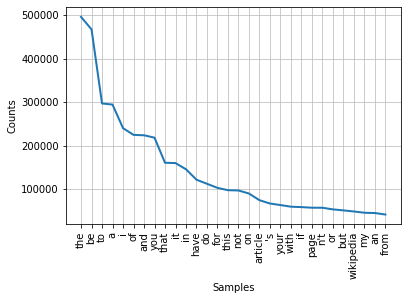

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [56]:
fd.plot(30,cumulative=False)

<b> Визуализация облака слов

In [41]:
text_raw = " ".join(df['ready_text'])

In [42]:
#%pip install wordcloud
#from wordcloud import WordCloud 
#import matplotlib.pyplot as plt
#%matplotlib inline
#wordcloud = WordCloud().generate(text_raw)

<b>Подготовка выборок

In [44]:
train, test = train_test_split(df, test_size=0.1, random_state=12345)

y_train = train['toxic']
X_train = train['ready_text_rude']

y_test = test['toxic']
X_test = test['ready_text_rude']

print(
    f'Выборка разделена в пропорциях:\n'
    f'{(len(X_train)/len(df)):.0%} — тренировочная;\n'
    f'{(len(X_test)/len(df)):.0%} — тестовая.\n'
)

Выборка разделена в пропорциях:
90% — тренировочная;
10% — тестовая.



In [45]:
stopwords_ = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords_)
tf_idf_train = count_tf_idf.fit_transform(tqdm(X_train)) #добавил 

  0%|          | 0/143362 [00:00<?, ?it/s]

In [46]:
#print(tf_idf)
print("Размер матрицы:", tf_idf_train.shape)

Размер матрицы: (143362, 148098)


In [47]:
tf_idf_test = count_tf_idf.transform(X_test)
print("Размер матрицы tf-idf_test:", tf_idf_test.shape)

Размер матрицы tf-idf_test: (15930, 148098)


Вывод:
* В комментариях нет дубликатов.
* В текстах комментариев встречаются «мусорные» символы, которые нужно убрать.
* Данные не сбалансированы по целевому признаку toxic.
* Провёл лемматизацию и очистил текст от лишних символов.
* Подготовил выборки.

## Обучение

<b>Модель Логистическя регрессия

In [48]:
model = LogisticRegression(solver='liblinear', class_weight = 'balanced', random_state=12345)
parameters = {
    'C': [10],  # были варианты: 1, 5, 15
    'penalty': ['l2'],  # был вариант: 'l1'
    'max_iter': [100],  # были варианты: 50, 200, 250
}
lin_grid = GridSearchCV(model, parameters, scoring='f1', cv=3)

In [49]:
%%time
lin_grid.fit(tf_idf_train, y_train)
lin_fit_score = lin_grid.best_score_
print(f'Лучший показатель F1: {lin_fit_score:.3f}')


Лучший показатель F1: 0.754
CPU times: user 53.2 s, sys: 47.8 s, total: 1min 41s
Wall time: 1min 41s


<b>Модель LGBMClassifier

In [ ]:
model = LGBMClassifier(random_state=12345, class_weight='balanced')
parameters = {
    'max_depth': [-1],  # были варианты: 5, 8, 10
    'num_leaves': [50],  # были варианты: 10, 50, 100
    'learning_rate': [0.1],  # были варианты: 0.1, 0.5, 1
    'n_estimators' : [100],  # были варианты: 250, 500
}
lgbm_grid = GridSearchCV(model, parameters, scoring='f1', cv=3, n_jobs=-1)

In [ ]:
%%time
lgbm_grid.fit(tf_idf_train, y_train)
lgbm_fit_score = lgbm_grid.best_score_
print(
    f'Лучший показатель F1: {lgbm_fit_score:.3f}'
)

<b>Модель RandomForestClassifier

In [ ]:
model = RandomForestClassifier(random_state=12345, class_weight='balanced')
parameters = {
    'max_depth': [10, 20],
    'min_samples_split': [4, 8, 12]
}
rfc_grid = GridSearchCV(model, parameters, scoring='f1', cv=3, n_jobs=-1)

In [ ]:
%%time
rfc_grid.fit(tf_idf_train, y_train)
rfc_fit_score = rfc_grid.best_score_
print(
    f'Лучший показатель F1: {rfc_fit_score:.3f}'
)

Вывод: 
Обучил три модели.
По всем моделям (Логистическя регрессия, LGBMClassifier и RandomForestClassifier) удалось получить предварительный расчёт показателя F1 на обучающей выборке.


<b>ТЕСТИРОВАНИЕ

<b>Модель Логистическя регрессия

In [ ]:
%%time
predictions = lin_grid.predict(tf_idf_test)
lin_f1 = f1_score(y_test, predictions)
lin_conf_mat = confusion_matrix(y_test, predictions)

print(
    f'F1-score: {lin_f1:.3f}\n'
    f'Количество истинно отрицательных результатов: {lin_conf_mat[0][0]}\n'
    f'Количество ложноотрицательных результатов: {lin_conf_mat[1][0]}\n'
    f'Количество истинно положительных результатов: {lin_conf_mat[1][1]}\n'
    f'Количество ложноположительных результатов: {lin_conf_mat[0][1]}\n'
)

<b>Модель LGBMClassifier

In [ ]:
#%%time
#predictions = lgbm_grid.predict(tf_idf_test)
#lgbm_f1 = f1_score(y_test, predictions)
#lgbm_conf_mat = confusion_matrix(y_test, predictions)

#print(
#    f'F1-score: {lgbm_f1:.3f}\n'
#    f'Количество истинно отрицательных результатов: {lgbm_conf_mat[0][0]}\n'
#    f'Количество ложноотрицательных результатов: {lgbm_conf_mat[1][0]}\n'
#    f'Количество истинно положительных результатов: {lgbm_conf_mat[1][1]}\n'
#    f'Количество ложноположительных результатов: {lgbm_conf_mat[0][1]}\n'
#)

<b>Модель RandomForestClassifier

In [ ]:
#%%time
#predictions = rfc_grid.predict(tf_idf_test)
#rfc_f1 = f1_score(y_test, predictions)
#rfc_conf_mat = confusion_matrix(y_test, predictions)

#print(
#    f'F1-score: {rfc_f1:.3f}\n'
#    f'Количество истинно отрицательных результатов: {rfc_conf_mat[0][0]}\n'
#    f'Количество ложноотрицательных результатов: {rfc_conf_mat[1][0]}\n'
#    f'Количество истинно положительных результатов: {rfc_conf_mat[1][1]}\n'
#    f'Количество ложноположительных результатов: {rfc_conf_mat[0][1]}\n'
#)

 


Финальное тестирование на тест выборке проводим только на лучшей модели    
    

<b>Общий вывод
Лучший результат показала модель Логистическя регрессия.
Достигнут целевой порог — F1-score выше 0.75. Кроме того, у этой модели лучшая скорость обучения и предсказания.
Также у этой модели наименьший показатель ложноотрицательных результатов.
Для текущей задачи — отправки токсичных комментариев на модерацию — это наиболее существенный показатель.
Так меньше всего токсичных комментариев по ошибке минует модерацию.